**GENAI STATEMENT:**  
I did not use generative AI for this assignment

In [1]:
# import packages:
import re
import boto3
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cassandra import ConsistencyLevel
from cassandra_sigv4.auth import SigV4AuthProvider
from ssl import SSLContext, PROTOCOL_TLSv1_2, CERT_REQUIRED
from cassandra.concurrent import execute_concurrent_with_args
from cassandra.cluster import Cluster, ExecutionProfile, EXEC_PROFILE_DEFAULT

In [2]:
# establish connection

# set to memory and read only false because we are creating new tables:
conn = duckdb.connect(database=':memory:', read_only=False)

# read in each file as a table w/ sql:
db = conn.execute("""
    CREATE TABLE PRESCRIPTIONS AS SELECT * FROM read_csv_auto('../data/PRESCRIPTIONS.csv');
    CREATE TABLE PATIENTS AS SELECT * FROM read_csv_auto('../data/PATIENTS.csv');
    CREATE TABLE ICUSTAYS AS SELECT * FROM read_csv_auto('../data/ICUSTAYS.csv');
    CREATE TABLE DRGCODES AS SELECT * FROM read_csv_auto('../data/DRGCODES.csv');
    CREATE TABLE D_ICD_PROCEDURES AS SELECT * FROM read_csv_auto('../data/D_ICD_PROCEDURES.csv');
    CREATE TABLE PROCEDURES_ICD AS SELECT * FROM read_csv_auto('../data/PROCEDURES_ICD.csv');
    CREATE TABLE ADMISSIONS AS SELECT * FROM read_csv_auto('../data/ADMISSIONS.csv');
""")

# display tables:
conn.sql('SHOW TABLES;')

┌──────────────────┐
│       name       │
│     varchar      │
├──────────────────┤
│ ADMISSIONS       │
│ DRGCODES         │
│ D_ICD_PROCEDURES │
│ ICUSTAYS         │
│ PATIENTS         │
│ PRESCRIPTIONS    │
│ PROCEDURES_ICD   │
└──────────────────┘

We will use a subset of the tables provided in the MIMIC-III database:


*   ADMISSIONS.csv
*   DRGCODES.csv
*   D_ICD_PROCEDURES.csv
*   ICUSTAYS.csv
*   PATIENTS.csv
*   PROCEDURES_ICD.csv
*   PRESCRIPTIONS.csv (new)

***PART ONE: RELATIONAL***

Answer the following analysis questions along with your queries.  
For each question, provide the following four pieces of information:  
> A. the SQL query,  
    B. a brief explanation of the query (i.e., what operations are performed by the major parts of the query),  
    C. the first several lines of your resulting table, and  
    D. a summary of your findings. If it benefits to use a graph, include your graph at the end of your answer, with clear labels and caption.  
  
The analysis questions are:  
> 1. Create a summary of type of drugs and their total amount used by ethnicity. Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.  
> 2. Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). Report the top three procedures, along with the name of the procedures, performed in each age group.  
> 3. How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?  

,ethnicity,drug_type,total_use
0,WHITE,MAIN,5420
1,WHITE,BASE,1743
2,HISPANIC/LATINO - PUERTO RICAN,MAIN,860
3,BLACK/AFRICAN AMERICAN,MAIN,476
4,HISPANIC/LATINO - PUERTO RICAN,BASE,298


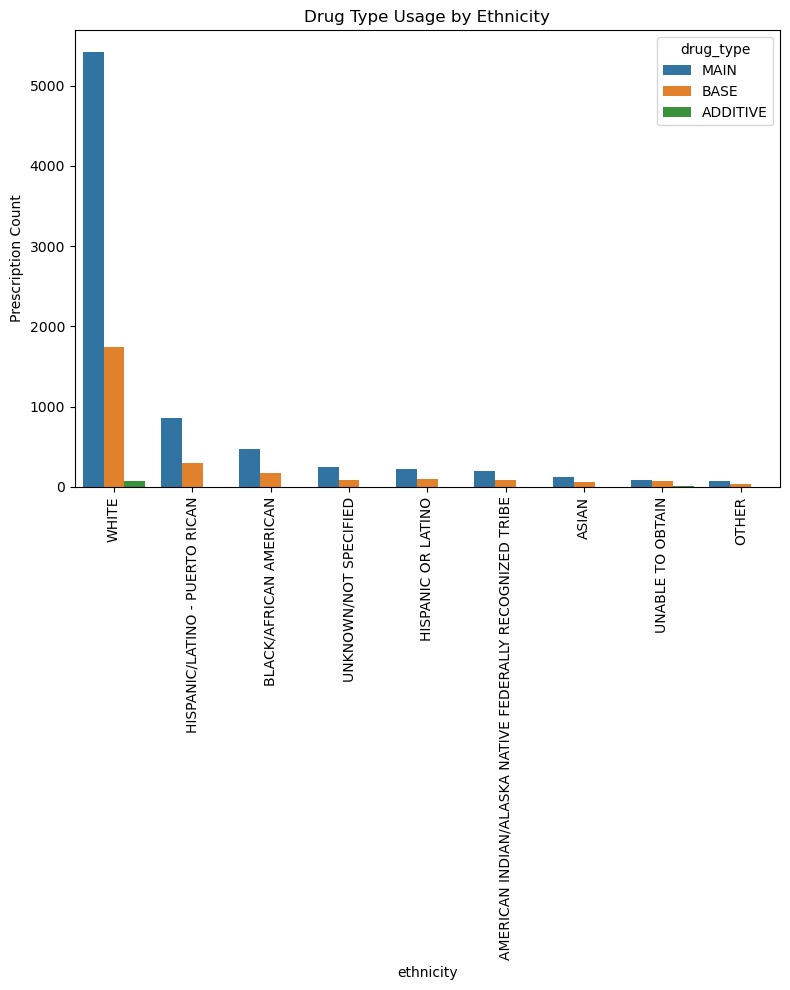

In [3]:
# Create a summary of type of drugs and their total amount used by ethnicity. 
# Report the top usage in each ethnicity group (may have to make certain assumptions in calculating their total amount)

# look at different ethnicities and drug_types from tables
raw1 = conn.sql(
    """
    SELECT 
        A.ethnicity,
        PR.drug_type,
    FROM PRESCRIPTIONS PR
    JOIN ADMISSIONS A ON PR.hadm_id = A.hadm_id
    """
).df()

# raw.head(10)

# Find usage by ethnicity:
df1 = conn.sql(
    """
    SELECT 
        A.ethnicity,
        PR.drug_type, 
        COUNT(*) as total_use 
    FROM PRESCRIPTIONS PR
    JOIN ADMISSIONS A ON PR.hadm_id = A.hadm_id
    WHERE drug_type IS NOT NULL
    GROUP BY ethnicity, drug_type
    ORDER BY total_use DESC
    """
).df()

# first several lines of resulting table:
display(df1.head())

# plot bar chart:
plt.figure(figsize=(8, 10))
sns.barplot(data=df1, x='ethnicity', y='total_use', hue='drug_type')
plt.title("Drug Type Usage by Ethnicity")
plt.xticks(rotation=90)
plt.ylabel("Prescription Count")
plt.tight_layout()
plt.show()

***the top usage in each ethnic group are the main drugs***

In [4]:
# Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80).
# Report the top three procedures, along with the name of the procedures, performed in each age group.

# import relevant columns from respective tables:
    # icd9_code (PROCEDURES_ICD and D_ICD_PROCEDURES), short title (D_ICD_PROCEDURES), subject_ID (PROCEDURES_ICD, PATIENTS and ADMISSIONS), 
    # admittime (ADMISSIONS),  dischtime(PATIENTS), dob (PATIENTS)
conn.sql(
    """
    CREATE TABLE QUESTION02 AS
    SELECT 
        d.short_title,
        a.admittime,
        p.dob,
        NULL AS age_group
    FROM procedures_icd PR
    JOIN d_icd_procedures D ON PR.icd9_code = D.icd9_code
    JOIN admissions A ON PR.hadm_id = A.hadm_id
    JOIN patients P ON A.subject_id = P.subject_id
    """
)

In [5]:
# to get age, use admit date and dob, convert to date and divide to years:
    # age = ROUND(ROUND(CAST(admittime AS DATE) - CAST(dob AS DATE), 1) / 365.25)

#  update age_group col:
conn.sql(
    """
    ALTER TABLE QUESTION02 ALTER COLUMN age_group TYPE TEXT;
""")

conn.sql(
    """
    UPDATE QUESTION02
    SET age_group = CASE
        WHEN ROUND(ROUND(CAST(admittime AS DATE) - CAST(dob AS DATE), 1) / 365.25) <= 19 THEN '<=19'
        WHEN ROUND(ROUND(CAST(admittime AS DATE) - CAST(dob AS DATE), 1) / 365.25) BETWEEN 20 AND 49 THEN '20-49'
        WHEN ROUND(ROUND(CAST(admittime AS DATE) - CAST(dob AS DATE), 1) / 365.25) BETWEEN 50 AND 79 THEN '50-79'
        WHEN ROUND(ROUND(CAST(admittime AS DATE) - CAST(dob AS DATE), 1) / 365.25) >= 80 THEN '>=80'
        ELSE 'Unknown'
    END;
    """
)

,age_group,short_title,procedure_count
0,<=19,Venous cath NEC,2
1,<=19,Cl fx reduc-femur,1
2,<=19,Other skeletal traction,1
3,20-49,Venous cath NEC,9
4,20-49,Entral infus nutrit sub,7


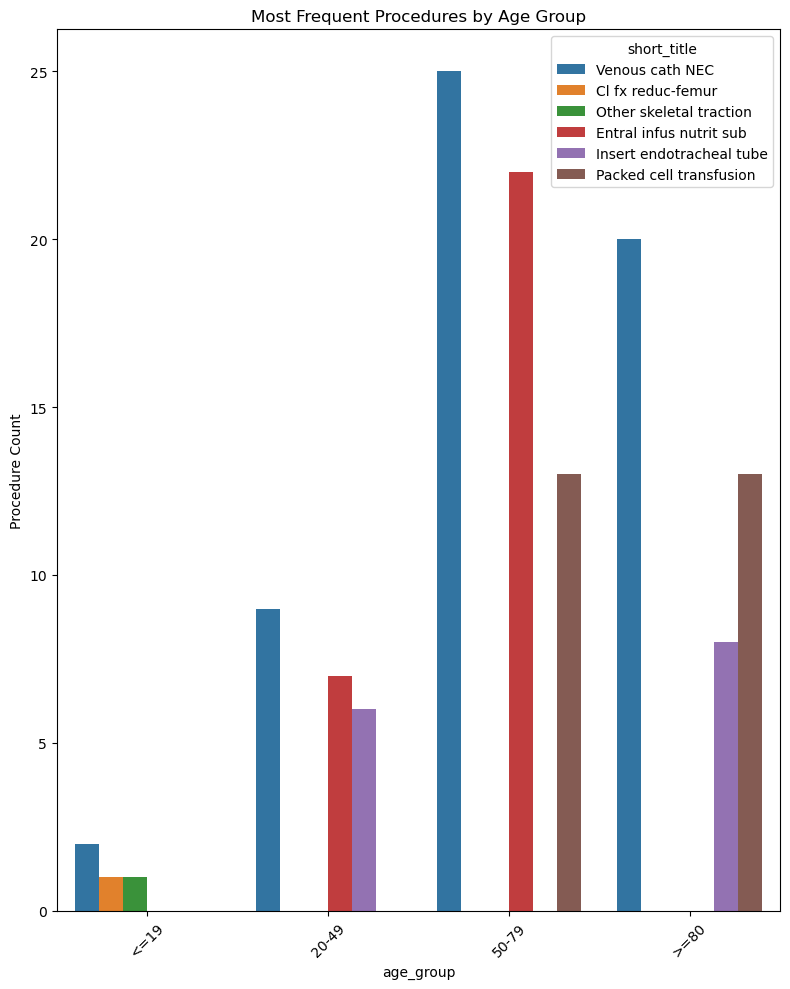

In [6]:
# look at different age groups and procedures from tables
raw2 = conn.sql(
    """
    SELECT 
        short_title,
        age_group,
    FROM QUESTION02
    """
).df()

# raw2.head(10)

# get the top three procedures per age group:
df2 = conn.execute(
    """
    WITH procedures_by_age_group AS (
        SELECT age_group, short_title, COUNT(*) AS procedure_count
        FROM QUESTION02
        GROUP BY age_group, short_title
    ),
    ranked AS (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY age_group ORDER BY procedure_count DESC) AS rank
        FROM procedures_by_age_group
    )
    SELECT age_group, short_title, procedure_count
    FROM ranked
    WHERE rank <= 3
    ORDER BY 
        CASE age_group
            WHEN '<=19' THEN 1
            WHEN '20-49' THEN 2
            WHEN '50-79' THEN 3
            WHEN '>=80' THEN 4
            ELSE 6
        END,
        procedure_count DESC
""").df()

display(df2.head())

# plot bar chart
plt.figure(figsize=(8, 10))
sns.barplot(data=df2, x='age_group', y='procedure_count', hue='short_title', order = ["<=19", "20-49", "50-79", ">=80"])
plt.title("Most Frequent Procedures by Age Group")
plt.xticks(rotation=45)
plt.ylabel("Procedure Count")
plt.tight_layout()
plt.show()

***The top 3 procedureds reported for each age group are as follows:***
* **<=19: Venous cath NEC, Other skeletal traction, vertebral fx repair**
* **20-49: Venous cath NEC, Entral infus nutrit sub, insert endotracheal tube**
* **50-79:Venous cath NEC, Entral infus nutrit sub, packed cell transfusion**
* **>=80: Venous cath NEC, insert endotracheal tube, packed cell transfusion**

In [ ]:
# How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?

# create a table with ICU stay time, gender, and ethnicity:
    # outtime (ICUSTAYS), intime (ICUSTAYS), subject_ID (ADMISSIONS, ICUSTAYS, PATIENTS),
    # ethnicity (ADMISSIONS), gender (PATIENTS)
    # stay_time = outtime - inttime 
conn.execute(""" 
    CREATE TABLE QUESTION03 AS
    SELECT 
        i.intime,
        i.outtime,
        a.ethnicity,
        p.gender, 
        CAST(i.outtime AS DATE) - CAST(i.intime AS DATE) as stay_time_days
    FROM icustays i
    JOIN admissions a ON i.hadm_id = a.hadm_id
    JOIN patients p ON i.subject_id = p.subject_id;
""")

In [8]:
# look at different stay_times compared to ethnicities and genders from tables
raw3 = conn.sql(
    """
    SELECT 
        stay_time_days,
        ethnicity,
        gender,
    FROM QUESTION03
    """
).df()

# raw3.head()

# report how long individuals stay in the ICU in general: average time, range, standard deviation of stays...
conn.execute("""
    SELECT 
        AVG(stay_time_days) AS avg_stay,
        MAX(stay_time_days) - MIN(stay_time_days) AS range_stay,
        STDDEV(stay_time_days) AS stddev_stay
    FROM QUESTION03
""").df()

,avg_stay,range_stay,stddev_stay
0,4.426471,36,6.201114


***The average ICU stay is 4.42 days. The range of stays is 36 days with the maximum stay being 36 days and minimum 0 days.
The standard deviation of stays is 6.2 days***

,ethnicity,stay_time_days,count
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,1,1
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,22,1
2,ASIAN,1,1
3,ASIAN,7,1
4,BLACK/AFRICAN AMERICAN,1,2


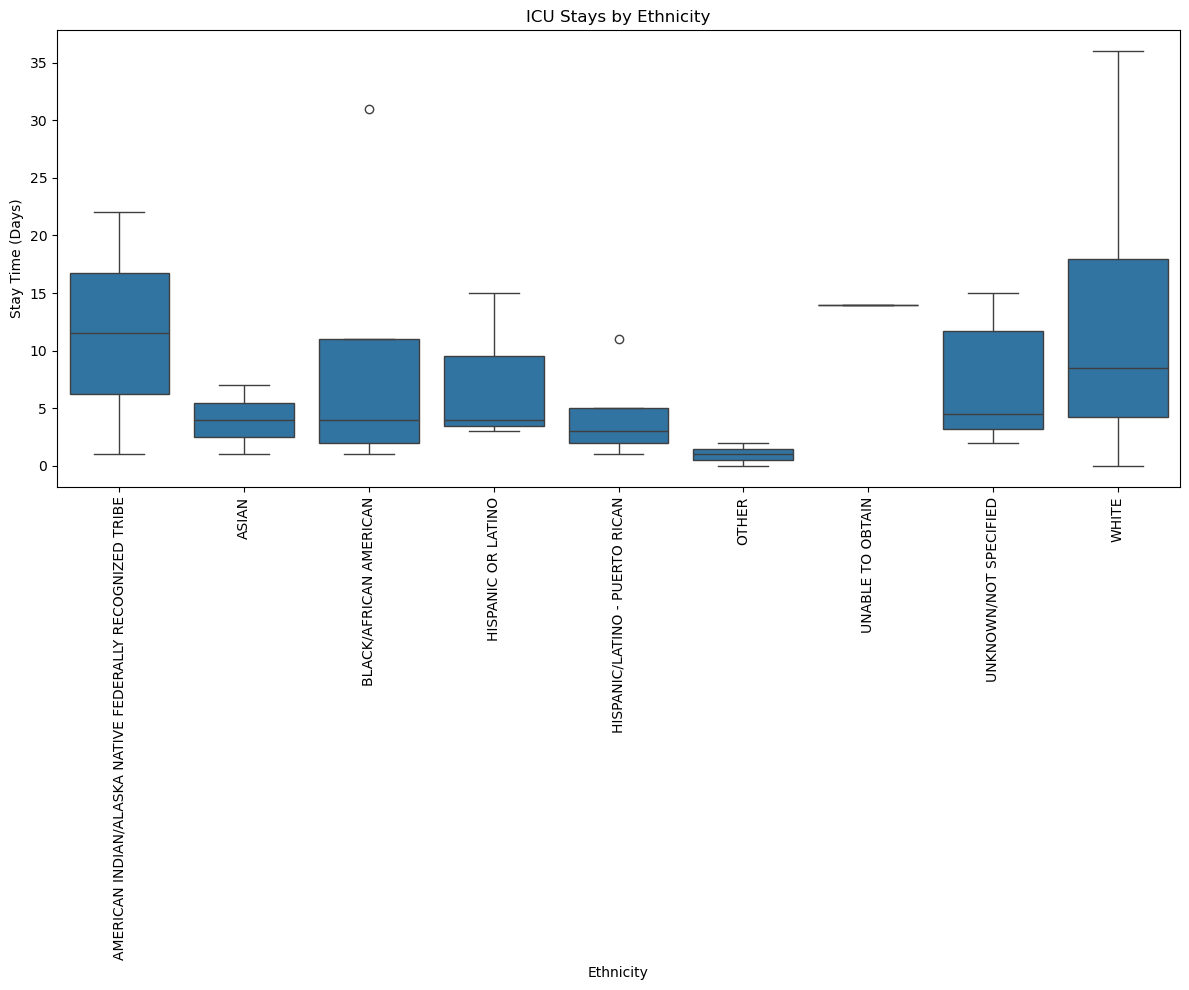

In [9]:
# group stays by ethnicity:
df3e = conn.execute("""
    SELECT ethnicity, stay_time_days, COUNT(*) as count
    FROM QUESTION03
    GROUP BY ethnicity, stay_time_days
    ORDER BY ethnicity, stay_time_days
""").df()

display(df3e.head())

# plot stays by ethnicity:
plt.figure(figsize=(12, 10))
sns.boxplot(x='ethnicity', y='stay_time_days', data=df3e)
plt.xticks(rotation=90, ha='center')
plt.title('ICU Stays by Ethnicity')
plt.ylabel('Stay Time (Days)')
plt.xlabel('Ethnicity')
plt.tight_layout()
plt.show()

***Based on the data, there is a difference in length of ICU stay by ethnicity. WHITE and AMERICAN INDIAN ethnicities tend to have the longest stays while OTHER appears to have the shortest stays. PUERTO RICAN and ASIAN ethnicities appear to have the shortest stays besides OTHER.*** 

,gender,stay_time_days,count
0,F,0,1
1,F,1,16
2,F,2,18
3,F,3,7
4,F,4,5


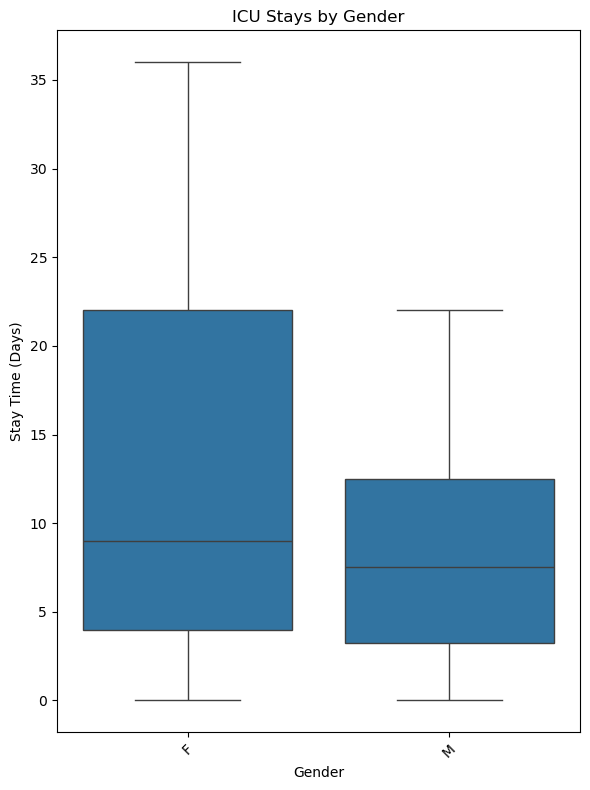

In [10]:
# group stays by gender:
df3e = conn.execute("""
    SELECT gender, stay_time_days, COUNT(*) as count
    FROM QUESTION03
    GROUP BY gender, stay_time_days
    ORDER BY gender, stay_time_days
""").df()

display(df3e.head())

# plot stays by ethnicity:
plt.figure(figsize=(6, 8))
sns.boxplot(x='gender', y='stay_time_days', data=df3e)
plt.xticks(rotation=45, ha='center')
plt.title('ICU Stays by Gender')
plt.ylabel('Stay Time (Days)')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

***While the average ICU stay duration is similar between males and females (around 7–8 days), the distribution of stay times differs. Females have a noticeably higher upper quartile, indicating that the longer-stay cases are more common or more extreme in this group. Additionally, the maximum observed stay for females (36 days) is significantly higher than that for males (22 days), suggesting the presence of potential outliers. These outliers may be skewing the distribution for females, even though the average stay remains close to that of males.***

***PART TWO: NON-RELATIONAL***

1. Verify access to Keyspaces via your Jupyter notebook on EC2. Follow the instructions from Keyspace connections lab.
2. Please sign and acknowledge the following statement:
> No copies of the AWS crendentials file is stored on any publicly accessible location, nor is the file in any way shared with anyone outside of DATA_ENG 300 (Spring 2025).
***Caridad Nugent***

3. For each of the analysis questions above, provide the following four pieces of information:  
    > a. Design a Cassandra table for the specific analysis. Report your table creation query.  
    > b. Upload the data into the table to facilitate answering the question. Report your code for uploading the data.  
    > c. Report the query for extracting relevant data to answer the question. You may choose to not aggregate within Cassandra. If so, indicate your post-extraction analyses and include the code for reaching the final answer.  
    > d. Verify that the extraction produces the desired data.

In [11]:
# set up connection to keyspace:

# ssl setup
ssl_context = SSLContext(PROTOCOL_TLSv1_2)
# ssl_context.load_verify_locations('sf-class2-root.crt')  # change your file path for locating the certificate
ssl_context.load_verify_locations('/home/jovyan/sf-class2-root.crt')
ssl_context.verify_mode = CERT_REQUIRED

# boto3 session setup
boto_session = boto3.Session(region_name="us-east-2")  # this AWS credentials is specific to `us-east-2` region

/tmp/ipykernel_21420/1569183444.py:4: DeprecationWarning: ssl.PROTOCOL_TLSv1_2 is deprecated
  ssl_context = SSLContext(PROTOCOL_TLSv1_2)


In [12]:
# authorization setup with SigV4
auth_provider = SigV4AuthProvider(boto_session)

In [13]:
#cluster setup 
cluster = Cluster(['cassandra.us-east-2.amazonaws.com'], 
                  ssl_context=ssl_context, 
                  auth_provider=auth_provider, 
                  port=9142)  # TLS only communicates on port 9142

# establishing connection to Keyspace
session = cluster.connect()

# For example, create a keyspace for HW2
r = session.execute('''
    CREATE KEYSPACE IF NOT EXISTS can1469_hw02 
    WITH replication = {'class': 'SingleRegionStrategy'};
    ''')
print(r.current_rows)

[]


In [14]:
# Define execution profile with LOCAL_QUORUM
execution_profile = ExecutionProfile(
    consistency_level=ConsistencyLevel.LOCAL_QUORUM
)

# Cluster setup with correct profile
cluster = Cluster(
    ['cassandra.us-east-2.amazonaws.com'],
    ssl_context=ssl_context,
    auth_provider=auth_provider,
    port=9142,
    execution_profiles={EXEC_PROFILE_DEFAULT: execution_profile}
)

# establishing connection to Keyspace
session = cluster.connect()
session.set_keyspace("can1469_hw02") # Replace with your keyspace

In [ ]:
# Create a summary of type of drugs and their total amount used by ethnicity. 
# Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.

# a. create the table
session.execute("""
CREATE TABLE IF NOT EXISTS can1469_hw02.drugs_by_ethnicity (
    ethnicity TEXT,
    drug_type TEXT,
    count COUNTER,
    PRIMARY KEY (ethnicity, drug_type)
) WITH CLUSTERING ORDER BY (drug_type ASC);
""")

In [17]:
# b. upload data into table: increase count of each combination at each occurrence
query = """
    UPDATE can1469_hw02.drugs_by_ethnicity
    SET count = count + 1
    WHERE ethnicity = ? AND drug_type = ?;
"""
prepared = session.prepare(query)

# execute concurrently because too slow otherwise
params = [(row.ethnicity, row.drug_type) for _, row in raw1.iterrows()]
results = execute_concurrent_with_args(session, prepared, params, concurrency=50)

In [18]:
# c. extract relevant data to answer question:
cassandra_df = session.execute(
    """
    SELECT ethnicity, drug_type, count 
    FROM can1469_hw02.drugs_by_ethnicity
    """
)

# d. Verify that the extraction produces the desired data
for row in cassandra_df:
    print(f"Ethnicity: {row.ethnicity}, Drug Type: {row.drug_type}, Count: {row.count}")

Ethnicity: OTHER, Drug Type: BASE, Count: 56
Ethnicity: OTHER, Drug Type: MAIN, Count: 144
Ethnicity: BLACK/AFRICAN AMERICAN, Drug Type: BASE, Count: 338
Ethnicity: BLACK/AFRICAN AMERICAN, Drug Type: MAIN, Count: 952
Ethnicity: WHITE, Drug Type: ADDITIVE, Count: 132
Ethnicity: WHITE, Drug Type: BASE, Count: 3486
Ethnicity: WHITE, Drug Type: MAIN, Count: 10840
Ethnicity: ASIAN, Drug Type: BASE, Count: 112
Ethnicity: ASIAN, Drug Type: MAIN, Count: 242
Ethnicity: HISPANIC/LATINO - PUERTO RICAN, Drug Type: BASE, Count: 596
Ethnicity: HISPANIC/LATINO - PUERTO RICAN, Drug Type: MAIN, Count: 1720
Ethnicity: UNKNOWN/NOT SPECIFIED, Drug Type: BASE, Count: 158
Ethnicity: UNKNOWN/NOT SPECIFIED, Drug Type: MAIN, Count: 490
Ethnicity: UNABLE TO OBTAIN, Drug Type: ADDITIVE, Count: 8
Ethnicity: UNABLE TO OBTAIN, Drug Type: BASE, Count: 136
Ethnicity: UNABLE TO OBTAIN, Drug Type: MAIN, Count: 178
Ethnicity: AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE, Drug Type: ADDITIVE, Count: 4
Ethnici

In [19]:
# Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). 
# Report the top three procedures, along with the name of the procedures, performed in each age group.

# a. create the table
session.execute("""
CREATE TABLE IF NOT EXISTS can1469_hw02.procedures_by_age_group (
    short_title TEXT,
    age_group TEXT,
    count COUNTER,
    PRIMARY KEY (age_group, short_title)
) WITH CLUSTERING ORDER BY (short_title ASC);
""")

In [20]:
# b. upload data into table: increase count of each combination at each occurrence
query = """
    UPDATE can1469_hw02.procedures_by_age_group
    SET count = count + 1
    WHERE age_group = ? AND short_title = ?;
"""
prepared = session.prepare(query)

# execute concurrently because too slow otherwise
params = [(row.age_group, row.short_title) for _, row in raw2.iterrows()]
results = execute_concurrent_with_args(session, prepared, params, concurrency=50)

In [21]:
# c. extract relevant data to answer question:
cassandra_df = session.execute(
    """
    SELECT age_group, short_title, count 
    FROM can1469_hw02.procedures_by_age_group
    """
)

# convert to pd
cassandra_df = pd.DataFrame(cassandra_df)

# sort and filter the top 3 for each age group in pd
cassandra_df = cassandra_df.sort_values(['age_group', 'count'], ascending = [True, False]).groupby('age_group').head(3)

# d. Verify that the extraction produces the desired data
for _, row in cassandra_df.iterrows():
    print(f"Age Group: {row['age_group']}, Procedure: {row['short_title']}, Count: {row['count']}")

Age Group: 20-49, Procedure: Venous cath NEC, Count: 18
Age Group: 20-49, Procedure: Entral infus nutrit sub, Count: 14
Age Group: 20-49, Procedure: Cont inv mec ven 96+ hrs, Count: 12
Age Group: 50-79, Procedure: Venous cath NEC, Count: 50
Age Group: 50-79, Procedure: Entral infus nutrit sub, Count: 44
Age Group: 50-79, Procedure: Packed cell transfusion, Count: 26
Age Group: <=19, Procedure: Venous cath NEC, Count: 4
Age Group: <=19, Procedure: Applic ext fix dev-femur, Count: 2
Age Group: <=19, Procedure: Atlas-axis fusion, Count: 2
Age Group: >=80, Procedure: Venous cath NEC, Count: 40
Age Group: >=80, Procedure: Packed cell transfusion, Count: 26
Age Group: >=80, Procedure: Insert endotracheal tube, Count: 16


In [22]:
# How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?

# How long do patients stay in the ICU?
# a. create the table
session.execute("""
CREATE TABLE IF NOT EXISTS can1469_hw02.ICU_stays (
    id INT,
    stay_time_days INT,
    PRIMARY KEY (id));
""")

# b. upload data into table: increase count of each combination at each occurrence
query = """
    INSERT INTO can1469_hw02.ICU_stays (id, stay_time_days) VALUES (?, ?);
"""
prepared = session.prepare(query)

# execute concurrently because too slow otherwise
params = [(i, row.stay_time_days) for i, row in raw3.iterrows()]
results = execute_concurrent_with_args(session, prepared, params, concurrency=50)

# c. extract relevant data to answer question:
cassandra_df = session.execute(
    """
    SELECT stay_time_days
    FROM can1469_hw02.ICU_stays
    """
)

# d. Verify that the extraction produces the desired data

# convert to pd
cassandra_df = pd.DataFrame(cassandra_df)

# find average, range, and standard deviation to compare to part 1
mean = cassandra_df['stay_time_days'].mean()
std = cassandra_df['stay_time_days'].std()
min_ = cassandra_df['stay_time_days'].min()
max_ = cassandra_df['stay_time_days'].max()
range_ = max_ - min_

print(f"Mean ICU Stay: {mean:.4f} days")
print(f"Standard Deviation: {std:.4f} days")
print(f"Range: {range_} days (min: {min_}, max: {max_})")

Mean ICU Stay: 4.4265 days
Standard Deviation: 6.2011 days
Range: 36 days (min: 0, max: 36)


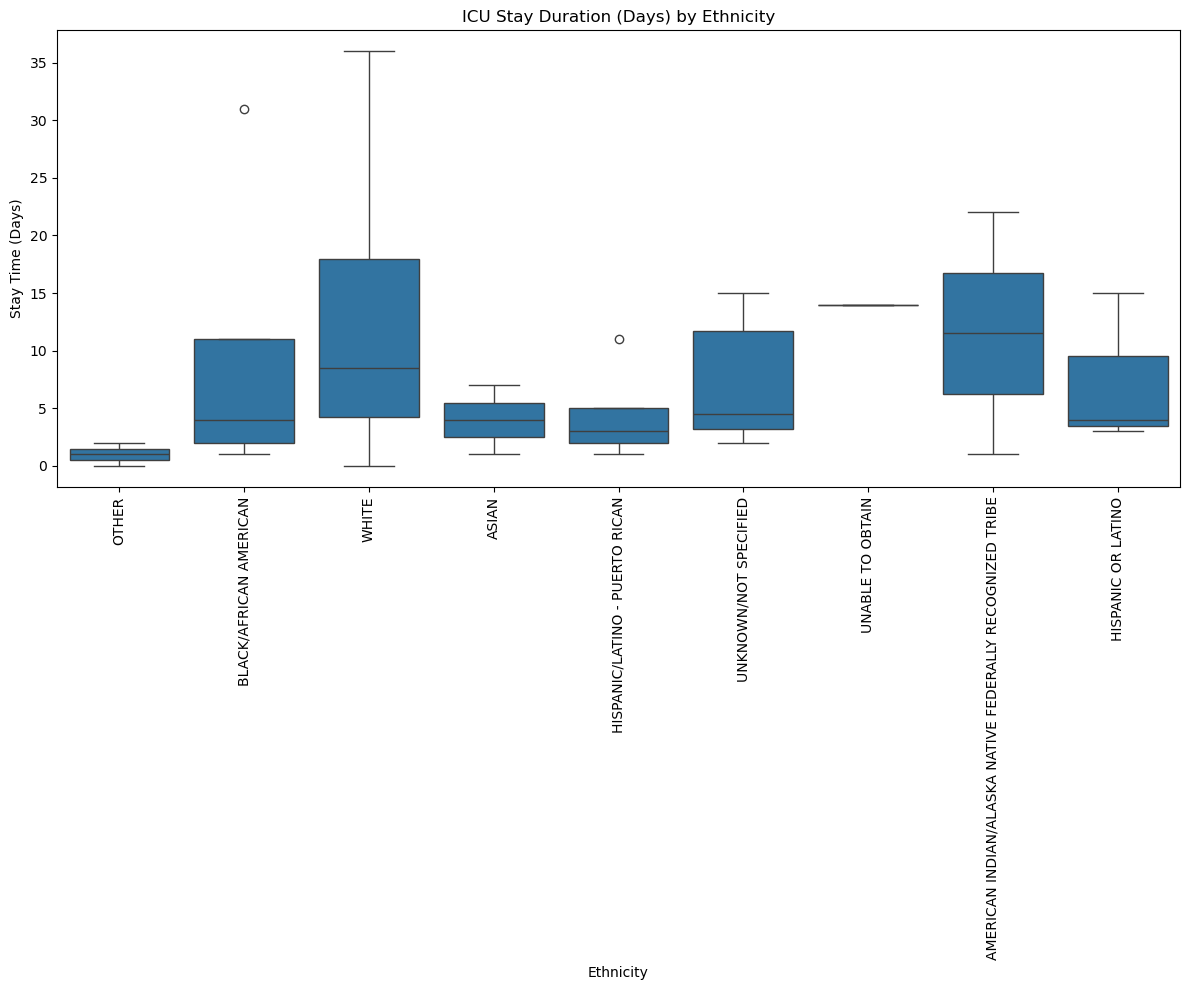

In [23]:
# Is there a difference in the ICU length of stay among ethnicity?

# a. create the table
session.execute("""
CREATE TABLE IF NOT EXISTS can1469_hw02.ICU_stay_by_ethnicity (
    stay_time_days INT,
    ethnicity TEXT,
    count COUNTER,
    PRIMARY KEY (ethnicity, stay_time_days));
""")

# b. upload data into table: increase count of each combination at each occurrence
query = """
    UPDATE can1469_hw02.ICU_stay_by_ethnicity
    SET count = count + 1
    WHERE stay_time_days = ? AND ethnicity = ?;
"""
prepared = session.prepare(query)

# execute concurrently because too slow otherwise
params = [(row.stay_time_days, row.ethnicity) for _, row in raw3.iterrows()]
results = execute_concurrent_with_args(session, prepared, params, concurrency=50)

# c. extract relevant data to answer question:
cassandra_df = session.execute(
    """
    SELECT stay_time_days, ethnicity, count 
    FROM can1469_hw02.ICU_stay_by_ethnicity
    """
)


# d. Verify that the extraction produces the desired data

# convert to pd
cassandra_df = pd.DataFrame(cassandra_df)

# display boxplots of stay times by ethnicity
plt.figure(figsize=(12, 10))
sns.boxplot(data=cassandra_df, x='ethnicity', y='stay_time_days')
plt.title("ICU Stay Duration (Days) by Ethnicity")
plt.xticks(rotation=90)
plt.ylabel("Stay Time (Days)")
plt.xlabel("Ethnicity")
plt.tight_layout()
plt.show()

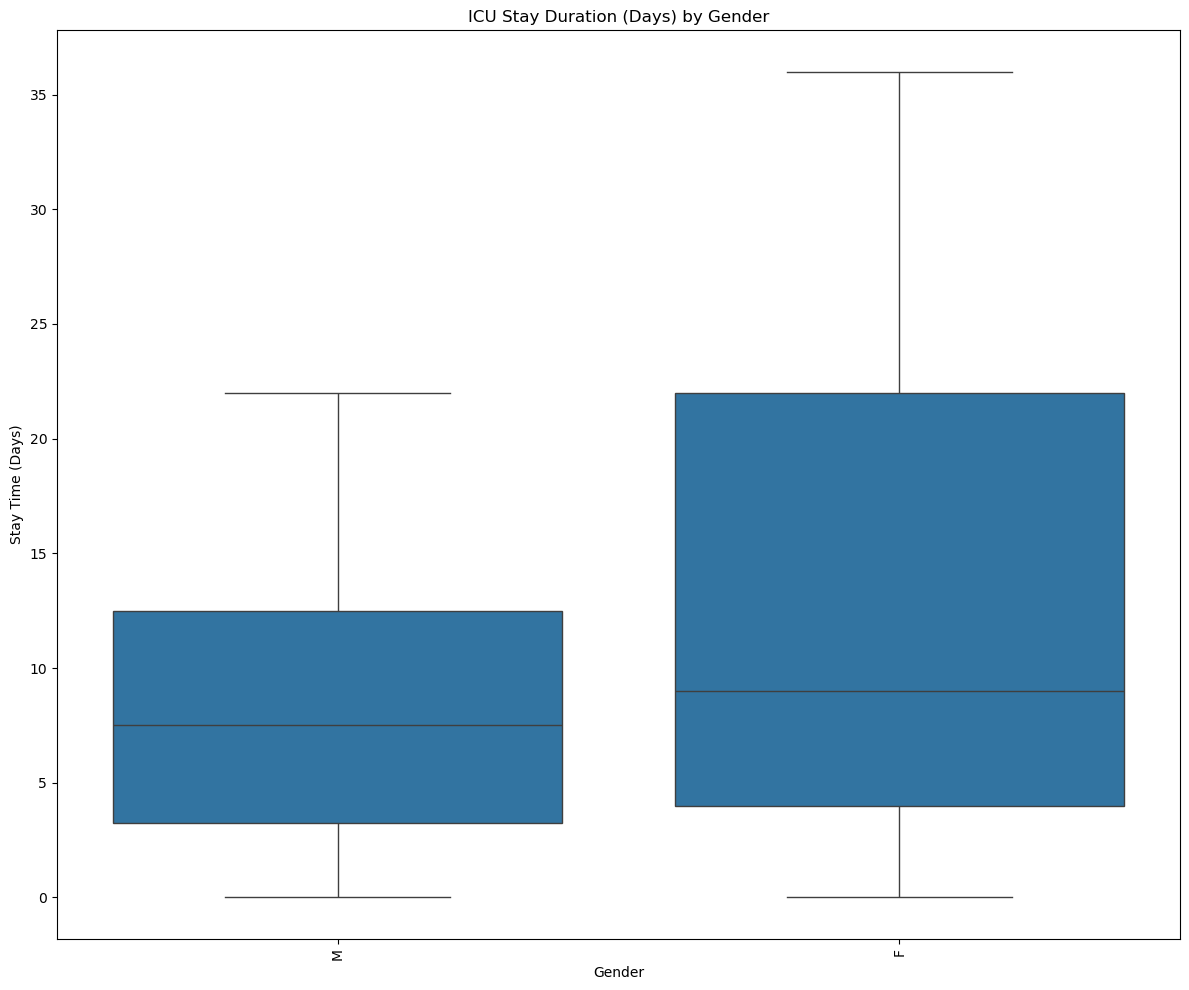

In [24]:
# Is there a difference in the ICU length of stay among gender?

# a. create the table
session.execute("""
CREATE TABLE IF NOT EXISTS can1469_hw02.ICU_stay_by_gender (
    stay_time_days INT,
    gender TEXT,
    count COUNTER,
    PRIMARY KEY (gender, stay_time_days));
""")

# b. upload data into table: increase count of each combination at each occurrence
query = """
    UPDATE can1469_hw02.ICU_stay_by_gender
    SET count = count + 1
    WHERE stay_time_days = ? AND gender = ?;
"""
prepared = session.prepare(query)

# execute concurrently because too slow otherwise
params = [(row.stay_time_days, row.gender) for _, row in raw3.iterrows()]
results = execute_concurrent_with_args(session, prepared, params, concurrency=50)

# c. extract relevant data to answer question:
cassandra_df = session.execute(
    """
    SELECT stay_time_days, gender, count 
    FROM can1469_hw02.ICU_stay_by_gender
    """
)

# d. Verify that the extraction produces the desired data

# convert to pd
cassandra_df = pd.DataFrame(cassandra_df)

# display boxplots of stay times by ethnicity
plt.figure(figsize=(12, 10))
sns.boxplot(data=cassandra_df, x='gender', y='stay_time_days')
plt.title("ICU Stay Duration (Days) by Gender")
plt.xticks(rotation=90)
plt.ylabel("Stay Time (Days)")
plt.xlabel("Gender")
plt.tight_layout()
plt.show()